In [ ]:
import os
import sys
import cv2
import torch
import numpy as np
import albumentations as A
import torch.optim as optim
import torch.utils.data as dt
import matplotlib.pyplot as plt
import torchvision.transforms as tf
import segmentation_models_pytorch as smp

from tqdm import tqdm
from imutils import paths
from torchmetrics import JaccardIndex
from sklearn.model_selection import train_test_split

epoch = 1
data_path = "DATASET/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
memory = True if device == 'cuda' else False

In [ ]:
def image_resize(img):
  height = img.shape[0]
  width = img.shape[1]
  problem = abs(height - width)
  sz = [int(problem / 2), problem - int(problem / 2), 0]
  if width >= height:
    img = cv2.copyMakeBorder(img, sz[0], sz[1], sz[2], sz[2], cv2.BORDER_CONSTANT)
  else:
    img = cv2.copyMakeBorder(img, sz[2], sz[2], sz[0], sz[1], cv2.BORDER_CONSTANT)
  img = cv2.resize(img, (224, 224))
  return img

In [ ]:
class SegmentationDataset(dt.Dataset):
    def __init__(self, imagPaths, maskPaths, transforms, transforms_affine = None):
        self.imagPaths = imagPaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        self.transforms_affine = transforms_affine
    def __len__(self):
        return len(self.imagPaths)
    def __getitem__(self, idx):
        imag = cv2.imread(self.imagPaths[idx], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)
        imag = image_resize(imag)
        mask = image_resize(mask)
        if self.transforms_affine != None:
            transformed = self.transforms_affine(image=imag, mask=mask)
            imag = transformed["image"]
            mask = transformed["mask"]
        imag = self.transforms(imag)
        mask = tf.Compose([tf.ToTensor()])(mask)
        return imag, mask

In [ ]:
class SegmentationTestDataset(dt.Dataset):
    def __init__(self, imagPaths, maskPaths, transforms):
        self.imagPaths = imagPaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        return len(self.imagPaths)
    def __getitem__(self, idx):
        imag = cv2.imread(self.imagPaths[idx], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)
        imag = image_resize(imag)
        mask = image_resize(mask)
        real = tf.Compose([tf.ToTensor()])(imag)
        mask = tf.Compose([tf.ToTensor()])(mask)
        imag = self.transforms(imag)
        return real, imag, mask

In [ ]:
def get_mean_std(train_loader):
    mean = torch.tensor([0., 0., 0.])
    std = torch.tensor([0., 0., 0.])
    for data in train_loader:
      img, mask = data
      mean += img.mean([0, 2, 3])
      std += img.std([0, 2, 3]) 
    mean /= len(train_loader)
    std /= len(train_loader)
    return mean, std

In [ ]:
bad_batch_size = 4
bad_Paths = sorted(list(paths.list_images(data_path + "gen_smoke_bad")))
bad_mask_Paths = sorted(list(paths.list_images(data_path + "gen_smoke_bad_masks")))
split_bad = train_test_split(bad_Paths, bad_mask_Paths, test_size=0.2)
(train_bad_imag, test_bad_imag) = split_bad[:2]
(train_bad_mask, test_bad_mask) = split_bad[2:]

good_batch_size = 4
good_Paths = sorted(list(paths.list_images(data_path + "orig_smoke")))
good_mask_Paths = sorted(list(paths.list_images(data_path + "orig_smoke_masks")))
split_good = train_test_split(good_Paths, good_mask_Paths, test_size=0.2)
(train_good_imag, test_good_imag) = split_good[:2]
(train_good_mask, test_good_mask) = split_good[2:]

test_batch_size = 1
test_Paths = sorted(list(paths.list_images(data_path + 'test')))
test_masks_Path = sorted(list(paths.list_images(data_path + 'test_mask')))

In [ ]:
transform_bad = tf.Compose([tf.ToTensor()])
bad_imag_train = SegmentationDataset(train_bad_imag, train_bad_mask, transform_bad)
bad_imag_test = SegmentationDataset(test_bad_imag, test_bad_mask, transform_bad)
bad_dataset_train = dt.DataLoader(bad_imag_train, batch_size=bad_batch_size, shuffle=True,
                                  pin_memory=memory, num_workers=os.cpu_count())
bad_dataset_test = dt.DataLoader(bad_imag_test, batch_size=bad_batch_size, shuffle=False,
                                 pin_memory=memory, num_workers=os.cpu_count())
bad_mean, bad_std = get_mean_std(bad_dataset_train)

transform_good = tf.Compose([tf.ToTensor()])
good_imag_train = SegmentationDataset(train_good_imag, train_good_mask, transform_good)
good_imag_test = SegmentationDataset(test_good_imag, test_good_mask, transform_good)
good_dataset_train = dt.DataLoader(good_imag_train, batch_size=good_batch_size, shuffle=True,
                                   pin_memory=memory, num_workers=os.cpu_count())
good_dataset_test = dt.DataLoader(good_imag_test, batch_size=good_batch_size, shuffle=False,
                                  pin_memory=memory, num_workers=os.cpu_count())
good_mean, good_std = get_mean_std(good_dataset_train)

transform_test = tf.Compose([tf.ToTensor()])
test_imag = SegmentationTestDataset(test_Paths, test_masks_Path, transform_test)
test_dataset = dt.DataLoader(test_imag, batch_size=test_batch_size, shuffle=False,
                             pin_memory=memory, num_workers=os.cpu_count())

In [ ]:
transform_bad = tf.Compose([tf.ToTensor(), tf.Normalize(bad_mean, bad_std),
                            tf.GaussianBlur(kernel_size=(7, 13), sigma=(0.25, 0.5))])
bad_imag_train = SegmentationDataset(train_bad_imag, train_bad_mask, transform_bad)
bad_imag_test = SegmentationDataset(test_bad_imag, test_bad_mask, transform_bad)
bad_dataset_train = dt.DataLoader(bad_imag_train, batch_size=bad_batch_size, shuffle=True,
                                  pin_memory=memory, num_workers=os.cpu_count())
bad_dataset_test = dt.DataLoader(bad_imag_test, batch_size=bad_batch_size, shuffle=False,
                                 pin_memory=memory, num_workers=os.cpu_count())

transform_good = tf.Compose([tf.ToTensor(), tf.Normalize(good_mean, good_std)])
transform_good_affine = A.Compose([A.Perspective(scale=(0.05, 0.3), p=1.),
                                   A.Affine(rotate=25, scale=(0.9, 0.9)),
                                   A.HorizontalFlip(p=.5)])
good_imag_train = SegmentationDataset(train_good_imag, train_good_mask, transform_good)
good_imag_test = SegmentationDataset(test_good_imag, test_good_mask, transform_good)
good_imag_train_trans = SegmentationDataset(train_good_imag, train_good_mask, transform_good, transform_good_affine)
good_imag_test_trans = SegmentationDataset(test_good_imag, test_good_mask, transform_good, transform_good_affine)
good_imag_train = dt.ConcatDataset([good_imag_train, good_imag_train_trans])
good_imag_test = dt.ConcatDataset([good_imag_test, good_imag_test_trans])
good_dataset_train = dt.DataLoader(good_imag_train, batch_size=good_batch_size, shuffle=True,
                                   pin_memory=memory, num_workers=os.cpu_count())
good_dataset_test = dt.DataLoader(good_imag_test, batch_size=good_batch_size, shuffle=False,
                                  pin_memory=memory, num_workers=os.cpu_count())

transform_test = tf.Compose([tf.ToTensor(), tf.Normalize(good_mean, good_std)])
test_imag = SegmentationTestDataset(test_Paths, test_masks_Path, transform_test)
test_dataset = dt.DataLoader(test_imag, batch_size=test_batch_size, shuffle=False,
                             pin_memory=memory, num_workers=os.cpu_count())

In [ ]:
def draw_plot(H):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 10))
    plt.plot(np.arange(1, len(H["loss"])+1), H["loss"], label="loss")
    plt.plot(np.arange(1, len(H["accu"])+1), H["accu"], label="accu")
    plt.title("Training Loss and Accu")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

In [ ]:
model = smp.Unet(
    encoder_name = "efficientnet-b7",
    encoder_depth = 5,
    encoder_weights = 'imagenet',
    activation = 'sigmoid'
).to(device)

loss_func = torch.nn.BCELoss().to(device)
accu_func = JaccardIndex(num_classes=2).to(device)

In [ ]:
def train(loss_fn, accu_func, train_loader, test_loader, learning_rate=1e-4, num_epoch=5, scheduler=5):
	global epoch, model, H
	best_epoch = 0
	best_epoch_ind = 0
	optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
	for e in range(num_epoch):
		model.train()
		totalLoss = 0
		totalAccu = 0
		if (e + 1) % scheduler == 0:
			learning_rate /= scheduler
		for (i, (x, y)) in tqdm(enumerate(train_loader), total=len(train_loader)):
			(x, y) = (x.to(device), y.to(device))
			pred = model(x)
			loss = loss_func(pred.squeeze(1), y.squeeze(1))
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			totalLoss += loss
		with torch.no_grad():
			model.eval()
			for (x, y) in test_loader:
				(x, y) = (x.to(device), y.to(device))
				pred = model(x)
				accu = accu_func(pred.squeeze(1), y.squeeze(1) > 0.5)
				totalAccu += accu

		avgLoss = totalLoss / len(train_loader)
		avgAccu = totalAccu / len(test_loader)
		H["loss"].append(avgLoss.cpu().detach().numpy())
		H["accu"].append(avgAccu.cpu().detach().numpy())
		print("[INFO] EPOCH: {}".format(epoch))
		print("loss: {:.4f}, accu: {:.4f}\n".format(avgLoss, avgAccu))

		if best_epoch < avgAccu:
			best_epoch = avgAccu
			best_epoch_ind = epoch
		torch.save(model.state_dict(), "EPOCH/model_weights-" + str(epoch) + ".pth")
		epoch += 1
	model.load_state_dict(torch.load("EPOCH/model_weights-" + str(best_epoch_ind) + ".pth", map_location=torch.device(device)))

In [ ]:
H = {"loss": [], "accu": []}
train(loss_func, accu_func, bad_dataset_train, bad_dataset_test, num_epoch=5)
draw_plot(H)

In [ ]:
H = {"loss": [], "accu": []}
train(loss_func, accu_func, good_dataset_train, good_dataset_test, num_epoch=15)
draw_plot(H)

AVG accu: 0.8494


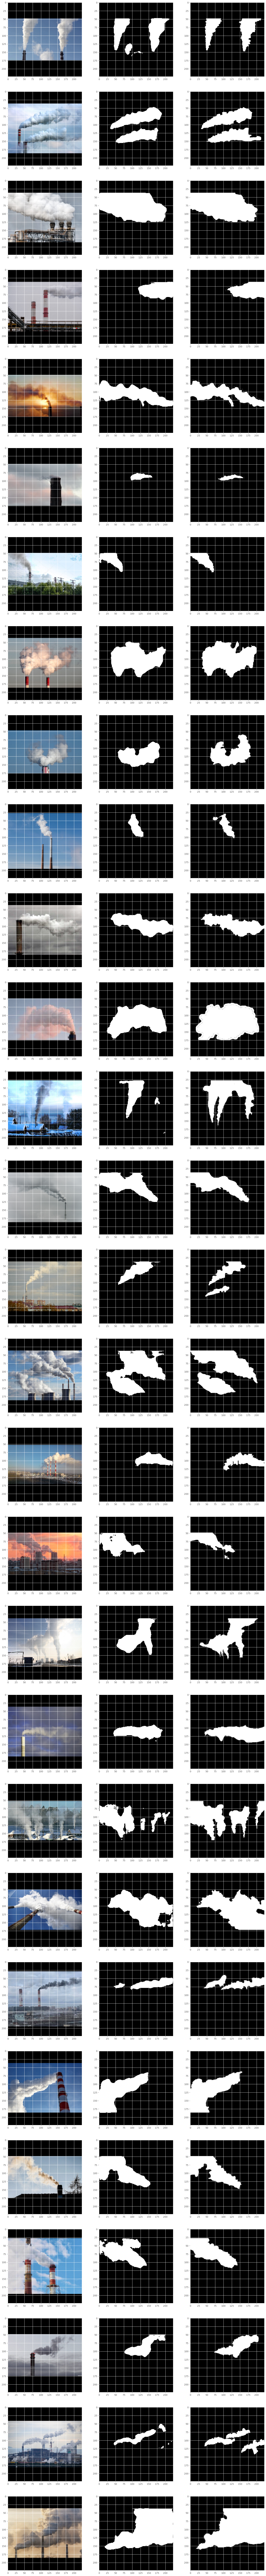

In [159]:
totalAccu = 0
fig, ax = plt.subplots(len(test_Paths), 3, figsize=(20, 200))
with torch.no_grad():
	model.eval()
	for (i, (r, x, y)) in enumerate(test_dataset):
		(r, x, y) = (r.to(device), x.to(device), y.to(device))
		p = model(x)
		ax[i][0].imshow(cv2.cvtColor(np.clip(r.squeeze(0).cpu().numpy().transpose(1, 2, 0), 0, 1), cv2.COLOR_RGB2BGR))
		ax[i][1].imshow(cv2.cvtColor(p.squeeze(0).cpu().numpy().round().transpose(1, 2, 0), cv2.IMREAD_GRAYSCALE))
		ax[i][2].imshow(cv2.cvtColor(y.squeeze(0).cpu().numpy().transpose(1, 2, 0), cv2.IMREAD_GRAYSCALE))
		totalAccu += accu_func(p.squeeze(1), y.squeeze(1) > 0.5)
avgAccu = totalAccu / len(test_dataset)
print("AVG accu: {:.4f}".format(avgAccu))

In [ ]:
# torch.save(model.state_dict(), "BEST model/28.09.pth")

In [ ]:
# model.load_state_dict(torch.load("BEST model/28.09.pth", map_location=torch.device(device)))

In [154]:
def write_video(file_path, frames, fps):
    num, w, h, ch = frames.shape
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        writer.write(np.uint8(frame))

    writer.release()

In [155]:
def read_video(file_path):
    global model
    video = cv2.VideoCapture(file_path)
    transforms = tf.Compose([tf.ToTensor(), tf.Normalize(good_mean, good_std)])
    images = []
    with torch.no_grad():
        model.eval()
        while(video.isOpened()):
            flag, x = video.read()
            if flag:
                x = image_resize(x)
                p = model(transforms(x).to(device).unsqueeze(0))
                p = p.cpu().numpy().squeeze().round()
                x = cv2.normalize(x, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_16U)
                p = np.expand_dims(cv2.normalize(p, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_16U), axis=2)
                res = x + p
                res[:, :, 1] = np.where(res[:, :, 0] <= 255, res[:, :, 1], 0)
                res[:, :, 2] = np.where(res[:, :, 0] <= 255, res[:, :, 2], 0)
                res[:, :, 0] = np.where(res[:, :, 0] <= 255, res[:, :, 0], 255)
                images.append(res)
            else:
                break
    video.release()
    return np.array(images)

In [156]:
# images = read_video('DATASET/video/0.mp4')
# write_video('vid.avi', images, 30)